In [131]:
###Note: Try to run the cells from start instead of jumpting to section wise as
##same variable names used across the Document
###Note: used chat-Gpt to understand concepts like Gradient boosting , Doc2Vec conversion,
### and using different types of vectorizers like TF-IDF,Count Vectorizer generating uni,bi,multi grams

In [132]:
#Importing all the packages
import pandas as pd
import string,nltk,json
import numpy as np
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from nltk.stem.porter import *
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn.model_selection import KFold,train_test_split,cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [133]:
news_corpus = pd.read_csv('news-train-1.csv')

In [134]:
news_corpus.columns

Index(['ArticleId', 'Text', 'Category'], dtype='object')

In [135]:
news_corpus.head()

,ArticleId,Text,Category
0,893,rangers seal old firm win goals from gregory v...,sport
1,1164,bt program to beat dialler scams bt is introdu...,tech
2,1696,new yob targets to be unveiled fifty new are...,politics
3,396,holmes is hit by hamstring injury kelly holmes...,sport
4,1862,capriati out of australian open jennifer capri...,sport


# Preprocessing from HW0


In [136]:
ps = PorterStemmer()
remove_punctuation = dict((ord(char), None) for char in string.punctuation)
def get_processed_tokens(text):
    lowers = text.lower()
    no_punctuation = lowers.translate(remove_punctuation)
    tokens = nltk.word_tokenize(no_punctuation)
    filtered = [word for word in tokens if not word in stopwords.words('english')]
    lemmatized_words = [ps.stem(item) for item in filtered ]
    Cleaned_text = ' '.join(lemmatized_words)
    return Cleaned_text
news_corpus['cleaned_text'] = news_corpus['Text'].apply(lambda x: get_processed_tokens(x))

In [137]:
news_corpus.head()

,ArticleId,Text,Category,cleaned_text
0,893,rangers seal old firm win goals from gregory v...,sport,ranger seal old firm win goal gregori vignal n...
1,1164,bt program to beat dialler scams bt is introdu...,tech,bt program beat dialler scam bt introduc two i...
2,1696,new yob targets to be unveiled fifty new are...,politics,new yob target unveil fifti new area get speci...
3,396,holmes is hit by hamstring injury kelly holmes...,sport,holm hit hamstr injuri kelli holm forc weekend...
4,1862,capriati out of australian open jennifer capri...,sport,capriati australian open jennif capriati becom...


# TF-IDF

In [138]:
X = news_corpus['cleaned_text']  # Features (cleaned_text)
y = news_corpus['Category']  # Target variable

# Randomly Splitting the data into training and testing ---> 80% train, 20% test
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


In [139]:
#TF-IDF vectorization to convert text data into numerical features:
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_valid_tfidf = tfidf_vectorizer.transform(X_valid)


# Decision Tree based on criterion

In [140]:
#Updating the Decision Tree criterion parameter
criterion_values = ["gini", "entropy"]
train_accuracies = []
valid_accuracies = []

for criterion in criterion_values:
    clf = tree.DecisionTreeClassifier(criterion=criterion)
    clf.fit(X_train_tfidf, y_train)
    y_train_pred = clf.predict(X_train_tfidf)
    y_valid_pred = clf.predict(X_valid_tfidf)

    train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate training and validation accuracy
    valid_accuracy = accuracy_score(y_valid, y_valid_pred)

    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)


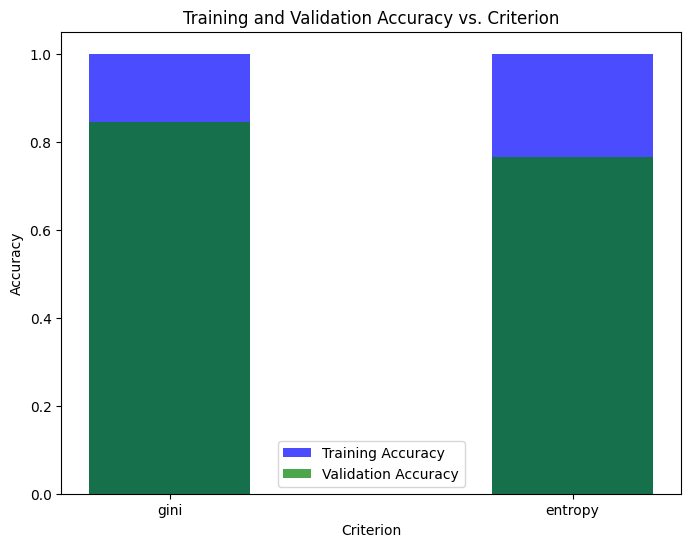

In [141]:
plt.figure(figsize=(8, 6))
plt.bar(criterion_values, train_accuracies, label='Training Accuracy', alpha=0.7, color='b', width=0.4)
plt.bar(criterion_values, valid_accuracies, label='Validation Accuracy', alpha=0.7, color='g', width=0.4)
plt.xlabel('Criterion')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Criterion')
plt.legend()
plt.show()

# Decision Tree w.r.t min samples leaf KFold = 5

min_samples_leaf | Training Accuracy  | Validation Accuracy  | std of Training  | std of Validation
1 | 100.0% | 77.29411764705883%| 0.0| 0.04655613867625738
3 | 94.79411764705883% | 78.47058823529412%| 0.004221382380708021| 0.04801960383990249
5 | 91.20588235294119% | 77.17647058823529%| 0.00704655797100641| 0.0451678913422411
7 | 88.76470588235294% | 76.82352941176471%| 0.011601813484303555| 0.04316220312433918
10 | 85.88235294117649% | 75.52941176470588%| 0.010440140793705218| 0.04985792964804023
50 | 70.20588235294119% | 64.70588235294117%| 0.02229481606852612| 0.06768541112302366
100 | 54.61764705882353% | 48.94117647058823%| 0.033965176548828344| 0.04099117974161021
200 | 37.38235294117647% | 32.47058823529412%| 0.005687964589945208| 0.03143620991973503




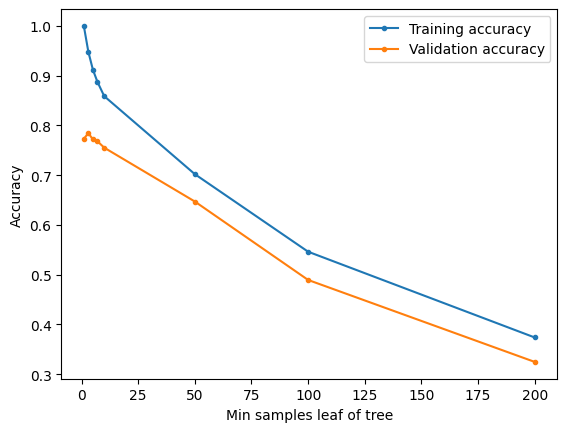

In [142]:
#### The below is the Sample code provided by professor and I modfied w.r.t min_samples_leaf.
def dtc_parameter_tune(train_val_X, train_val_y):
    min_samples_leaf = [1, 3, 5, 7, 10, 50, 100, 200]
    train_acc_all = []
    val_acc_all = []
    train_std_all = []
    val_std_all = []

    kf = KFold(n_splits = 5)
    print("min_samples_leaf | Training Accuracy  | Validation Accuracy  | std of Training  | std of Validation")
    for sample in min_samples_leaf:
        train_acc = []
        val_acc = []
        print("================================================================================================")
        for train_index, val_index in kf.split(train_val_X):

            train_X = train_val_X[train_index,:]
            val_X = train_val_X[val_index,:]

            train_y = train_val_y.iloc[train_index]
            val_y = train_val_y.iloc[val_index]

            dtc = tree.DecisionTreeClassifier(min_samples_leaf=sample)
            dtc.fit(train_X, train_y)
            train_acc.append(dtc.score(train_X, train_y))
            val_acc.append(dtc.score(val_X, val_y))


        avg_train_acc = sum(train_acc) / len(train_acc)
        avg_val_acc = sum(val_acc) / len(val_acc)
        std_train_acc = np.std(train_acc)
        std_val_acc = np.std(val_acc)
        print(f"{sample} | {avg_train_acc * 100}% | { avg_val_acc * 100}%| {std_train_acc}| {std_val_acc}")

        train_acc_all.append(avg_train_acc)
        val_acc_all.append(avg_val_acc)
        train_std_all.append(std_train_acc)
        val_std_all.append(std_val_acc)

    return min_samples_leaf, train_acc_all, val_acc_all,train_std_all,val_std_all

min_samples_leaf, train_acc_all, val_acc_all, train_std_all, val_std_all = dtc_parameter_tune(X_train_tfidf, y_train)

#Plotting the training and validation accuracies w.r.t min samples leaf
print("\n")
plt.plot(min_samples_leaf, train_acc_all, marker='.', label="Training accuracy")
plt.plot(min_samples_leaf, val_acc_all, marker='.', label="Validation accuracy")
plt.xlabel('Min samples leaf of tree')
plt.ylabel('Accuracy')
plt.legend()

# 5 fold Validation w.r.t w.r.t max features

max_features | Training Accuracy  | Validation Accuracy  | std of Training  | std of Validation
None        | 100.0%              | 77.52941176470588%    | 0.0            | 0.05038261907144437
sqrt        | 100.0%              | 69.41176470588236%    | 0.0            | 0.027840375449880557
log2        | 100.0%              | 64.8235294117647%    | 0.0            | 0.0380129280503612




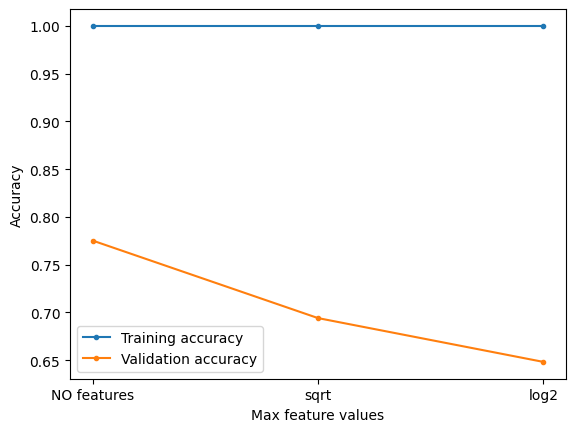

In [143]:
def dtc_parameter_tune(train_val_X, train_val_y):
    max_features_values = [None, 'sqrt', 'log2']
    train_acc_all = []
    val_acc_all = []

    kf = KFold(n_splits = 5)
    print("max_features | Training Accuracy  | Validation Accuracy  | std of Training  | std of Validation")
    for max_feature in max_features_values:
        train_acc = []
        val_acc = []
        train_std_all = []
        val_std_all = []
        print("=============================================================================================")
        for train_index, val_index in kf.split(train_val_X):

            train_X = train_val_X[train_index,:]
            val_X = train_val_X[val_index,:]

            train_y = train_val_y.iloc[train_index]
            val_y = train_val_y.iloc[val_index]

            dtc = tree.DecisionTreeClassifier(max_features=max_feature)
            dtc.fit(train_X, train_y)
            train_acc.append(dtc.score(train_X, train_y))
            val_acc.append(dtc.score(val_X, val_y))


        avg_train_acc = sum(train_acc) / len(train_acc)
        avg_val_acc = sum(val_acc) / len(val_acc)
        std_train_acc = np.std(train_acc)
        std_val_acc = np.std(val_acc)
        print(f"{max_feature}        | {avg_train_acc * 100}%              | { avg_val_acc * 100}%    | {std_train_acc}            | {std_val_acc}")

        train_acc_all.append(avg_train_acc)
        val_acc_all.append(avg_val_acc)
        train_std_all.append(std_train_acc)
        val_std_all.append(std_val_acc)

    return max_features_values, train_acc_all, val_acc_all,train_std_all,val_std_all

max_features_values, train_acc_all, val_acc_all,train_std_all,val_std_all = dtc_parameter_tune(X_train_tfidf, y_train)

# plot training/validation curves
print("\n")
max_features_values = ['NO features', 'sqrt', 'log2']
plt.plot(max_features_values, train_acc_all, marker='.', label="Training accuracy")
plt.plot(max_features_values, val_acc_all, marker='.', label="Validation accuracy")
plt.xlabel('Max feature values')
plt.ylabel('Accuracy')
plt.legend()


# Random Forest w.r.t n_estimators

Estimators | Training Accuracy  | Validation Accuracy  | std of Training  | std of Validation
50        | 100.0%              | 94.58823529411765%    | 0.0              | 0.016386339149628396
100        | 100.0%              | 95.41176470588235%    | 0.0              | 0.011406305546861952
150        | 100.0%              | 94.82352941176471%    | 0.0              | 0.01199769297315948
200        | 100.0%              | 95.52941176470588%    | 0.0              | 0.012112506048220003
250        | 100.0%              | 94.94117647058825%    | 0.0              | 0.01469411293740799




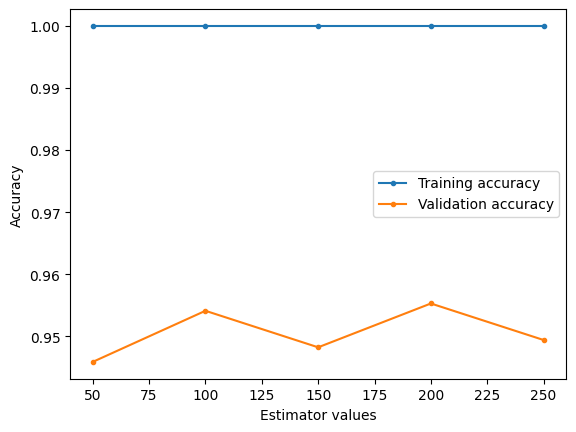

In [144]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

def random_parameter_tune(train_val_X, train_val_y):
    n_estimators_range = [50, 100, 150, 200, 250]
    train_acc_all = []
    val_acc_all = []

    kf = KFold(n_splits = 5)
    print("Estimators | Training Accuracy  | Validation Accuracy  | std of Training  | std of Validation")
    for estimator in n_estimators_range:
        train_acc = []
        val_acc = []
        train_std_all = []
        val_std_all = []
        print("============================================================================================")
        for train_index, val_index in kf.split(train_val_X):

            train_X = train_val_X[train_index,:]
            val_X = train_val_X[val_index,:]

            train_y = train_val_y.iloc[train_index]
            val_y = train_val_y.iloc[val_index]

            rf_model = RandomForestClassifier(n_estimators=estimator)
            rf_model.fit(train_X, train_y)
            train_acc.append(rf_model.score(train_X, train_y))
            val_acc.append(rf_model.score(val_X, val_y))


        avg_train_acc = sum(train_acc) / len(train_acc)
        avg_val_acc = sum(val_acc) / len(val_acc)
        std_train_acc = np.std(train_acc)
        std_val_acc = np.std(val_acc)
        print(f"{estimator}        | {avg_train_acc * 100}%              | { avg_val_acc * 100}%    | {std_train_acc}              | {std_val_acc}")

        train_acc_all.append(avg_train_acc)
        val_acc_all.append(avg_val_acc)
        train_std_all.append(std_train_acc)
        val_std_all.append(std_val_acc)

    return n_estimators_range, train_acc_all, val_acc_all,train_std_all,val_std_all

n_estimators_range, train_acc_all, val_acc_all, train_std_all, val_std_all = random_parameter_tune(X_train_tfidf, y_train)

# plot training/validation curves
print("\n")
plt.plot(n_estimators_range, train_acc_all, marker='.', label="Training accuracy")
plt.plot(n_estimators_range, val_acc_all, marker='.', label="Validation accuracy")
plt.xlabel('Estimator values')
plt.ylabel('Accuracy')
plt.legend()

# Random Forest w.r.t min_samples_leaf

min samples leaf | Training Accuracy  | Validation Accuracy  | std of Training  | std of Validation
       1        | 100.0% | 95.41176470588235%    | 0.0         | 0.013100622030188294
       2        | 100.0% | 94.94117647058825%    | 0.0         | 0.011527010554273768
       5        | 98.91176470588235% | 94.47058823529412%    | 0.004796913655970629         | 0.011527010554273779
       10        | 96.76470588235293% | 93.52941176470588%    | 0.0036021907982105436         | 0.012338927625531182
       20        | 94.79411764705881% | 91.52941176470588%    | 0.00470588235294116         | 0.012670976016787072




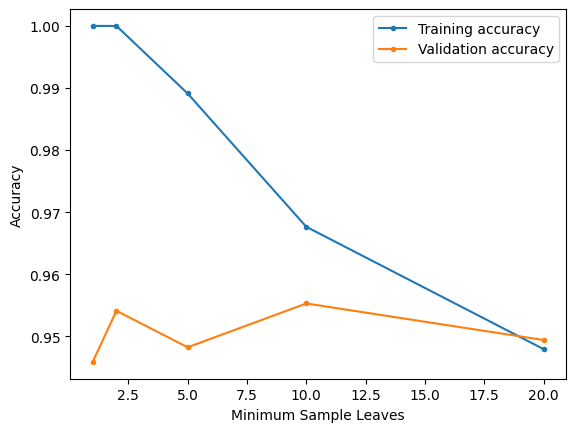

In [146]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier


def random_parameter_tune(train_val_X, train_val_y):

    min_samples_leaf_range = [1, 2, 5, 10, 20]
    train_acc_all = []
    val_acc_all = []

    kf = KFold(n_splits = 5)
    print("min samples leaf | Training Accuracy  | Validation Accuracy  | std of Training  | std of Validation")
    for min_samples_leaf in min_samples_leaf_range:
        train_acc = []
        val_acc = []
        train_std_all = []
        val_std_all = []
        print("===========================================================================================")
        for train_index, val_index in kf.split(train_val_X):

            train_X = train_val_X[train_index,:]
            val_X = train_val_X[val_index,:]

            train_y = train_val_y.iloc[train_index]
            val_y = train_val_y.iloc[val_index]

            rf_model = RandomForestClassifier(min_samples_leaf=min_samples_leaf)
            rf_model.fit(train_X, train_y)
            train_acc.append(rf_model.score(train_X, train_y))
            val_acc.append(rf_model.score(val_X, val_y))


        avg_train_acc = sum(train_acc) / len(train_acc)
        avg_val_acc = sum(val_acc) / len(val_acc)
        std_train_acc = np.std(train_acc)
        std_val_acc = np.std(val_acc)
        print(f"       {min_samples_leaf}        | {avg_train_acc * 100}% | { avg_val_acc * 100}%    | {std_train_acc}         | {std_val_acc}")

        train_acc_all.append(avg_train_acc)
        val_acc_all.append(avg_val_acc)
        train_std_all.append(std_train_acc)
        val_std_all.append(std_val_acc)

    return min_samples_leaf_range, train_acc_all, val_acc_all, train_std_all, val_std_all

min_samples_leaf, train_acc_all, val_acc_al, train_std_all, val_std_alll = random_parameter_tune(X_train_tfidf, y_train)

# plot training/validation curves
print("\n")
plt.plot(min_samples_leaf, train_acc_all, marker='.', label="Training accuracy")
plt.plot(min_samples_leaf, val_acc_all, marker='.', label="Validation accuracy")
plt.xlabel('Minimum Sample Leaves')
plt.ylabel('Accuracy')
plt.legend()

# Predicting Test Data Using Random Classifier

In [147]:
#Predicting the test data based on Random Classifier

X_train = news_corpus['cleaned_text']
y_train = news_corpus['Category']

test_data = pd.read_csv('news-test.csv')
test_data['cleaned_text'] = test_data['Text'].apply(lambda x: get_processed_tokens(x))
X_test = test_data['cleaned_text']


# Create a CountVectorizer to convert text data into numerical features
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)


rf_classifier = RandomForestClassifier(n_estimators=250)
rf_classifier.fit(X_train_vectorized, y_train)
y_pred = rf_classifier.predict(X_test_vectorized)
test_data['predicted_label'] = y_pred

final_data = test_data[['ArticleId','predicted_label']]

#saving the tested data with predicted labels to a CSV file
final_data.to_csv('labels1.csv', index=False,header=False)


# Test data prediction using Gradient Boost

In [151]:
#convert X_train, X_valid to list of words
ps = PorterStemmer()
remove_punctuation = dict((ord(char), None) for char in string.punctuation)
def get_processed_words(text):
    lowers = text.lower()
    no_punctuation = lowers.translate(remove_punctuation)
    tokens = nltk.word_tokenize(no_punctuation)
    filtered = [word for word in tokens if not word in stopwords.words('english')]
    lemmatized_words = [ps.stem(item) for item in filtered ]
    return lemmatized_words


In [152]:
news_corpus = pd.read_csv('news-train-1.csv')
news_corpus['cleaned_text'] = news_corpus['Text'].apply(lambda x: get_processed_words(x))
X_train = news_corpus['cleaned_text']
y_train = news_corpus['Category']

test_data = pd.read_csv('news-test.csv')
test_data['cleaned_text'] = test_data['Text'].apply(lambda x: get_processed_words(x))
X_test = test_data['cleaned_text']


# Create a doc2Vectorizer to convert text data into numerical features ----> Used ChatGpt to understand this Concept
tagged_data_train = [TaggedDocument(words=doc, tags=[str(i)]) for i, doc in enumerate(X_train)]
tagged_data_valid = [TaggedDocument(words=doc, tags=[str(i)]) for i, doc in enumerate(X_test)]

# Initialize and train the Doc2Vec model
doc2vec_model = Doc2Vec(vector_size=100, window=5, min_count=1, workers=4, epochs=20)
doc2vec_model.build_vocab(tagged_data_train)
doc2vec_model.train(tagged_data_train, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

X_train_doc2vec = [doc2vec_model.infer_vector(doc.words) for doc in tagged_data_train]
X_valid_doc2vec = [doc2vec_model.infer_vector(doc.words) for doc in tagged_data_valid]


In [156]:
#I am getting max accuracy at the following parameter setting, The training accuracy is 100%

gb_classifier = GradientBoostingClassifier(n_estimators=500, min_samples_split=10, max_features=1000, random_state=42)
gb_classifier.fit(X_train_doc2vec, y_train)
Y_train_pred = gb_classifier.predict(X_train_doc2vec)

train_accuracy = accuracy_score(y_train, Y_train_pred)
print(f"Training Accuracy: {train_accuracy:.2f}")

Y_valid_pred = gb_classifier.predict(X_valid_doc2vec)
test_data['predicted_label'] = Y_valid_pred
final_data = test_data[['ArticleId','predicted_label']]

final_data.to_csv('labels.csv', index=False,header=False)

Training Accuracy: 1.00
